# TD: GNN

In [ ]:
!pip install dgl-cu110

     |████████████████████████████████| 39.9 MB 1.7 MB/s 


In [ ]:
import argparse
from os import path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from dgl import batch
from dgl.data.ppi import LegacyPPIDataset
from dgl.nn.pytorch import GraphConv
from dgl.nn.pytorch import GATConv
from sklearn.metrics import f1_score
from torch import nn, optim
from torch.utils.data import DataLoader

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
MODEL_STATE_FILE = '/content/model_state.pth'

In [ ]:
class BasicGraphModel(nn.Module):

    def __init__(self, g, n_layers, input_size, hidden_size, output_size, nonlinearity):
        super().__init__()

        self.g = g
        self.layers = nn.ModuleList()
        self.layers.append(GraphConv(input_size, hidden_size, activation=nonlinearity))
        for i in range(n_layers - 1):
            self.layers.append(GraphConv(hidden_size, hidden_size, activation=nonlinearity))
        self.layers.append(GraphConv(hidden_size, output_size))

    def forward(self, inputs):
        outputs = inputs
        for i, layer in enumerate(self.layers):
            outputs = layer(self.g, outputs)

        return outputs

In [ ]:
class SuperGraphModel(nn.Module):
    def __init__(self,
                 g,
                 num_layers,
                 in_dim,
                 num_hidden,
                 num_classes,
                 heads,
                 activation,
                 feat_drop,
                 attn_drop,
                 negative_slope,
                 residual):
        super(SuperGraphModel, self).__init__()
        self.g = g
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        self.activation = activation
        # input projection (no residual)
        self.layers.append(GATConv(
            in_dim, num_hidden, heads[0], #50, 256, 4, ELU, FALSE= residuals à toi de voir, negative_s = 0.2 selon l'article
            feat_drop, attn_drop, negative_slope, False, self.activation))
        # hidden layers
        for l in range(1, num_layers):
            # due to multi-head, the in_dim = num_hidden * num_heads
            self.layers.append(GATConv( #heads = [4, 4, 6]
                num_hidden * heads[l-1], num_hidden, heads[l], #256 * 4, 256, 4
                feat_drop, attn_drop, negative_slope, residual, self.activation))
        # output projection
        self.layers.append(GATConv(
            num_hidden * heads[-2], num_classes, heads[-1], #256 * 4, 121, 6
            feat_drop, attn_drop, negative_slope, residual, None))

    def forward(self, inputs):
        h = inputs
        for l in range(self.num_layers):
            h = self.layers[l](self.g, h).flatten(1)
        # output projection
        logits = torch.sigmoid(self.layers[-1](self.g, h).mean(1))
        return logits

In [ ]:
class GATM(nn.Module):

    def __init__(self):
    super(GATM, self).__init__()
    self.layers = nn.ModuleList()
    self.g1 = GATConv(in_feats = 50, out_feats = 256, num_heads = 4, negative_slope = 0.2, activation = F.elu)
    self.g2 = GATConv(in_feats = 256, out_feats = 256, num_heads = 4, negative_slope = 0.2, activation = F.elu, residual = True)
    self.g3 = GATConv(in_feats = 256, out_feats = 121, num_heads = 6, negative_slope = 0.2, activation = F.elu, residual = True)
    self.g4 = GATConv(in_feats = 256, out_feats = 121, num_heads = 6, negative_slope = 0.2, activation = F.sigmoid, residual = True)

    def forward(self, inputs):
    x = self.g1(inputs).flatten(1)
    x = self.g2(x).flatten(1)
    x = self.g3(x).flatten(1)
    logits = self.g4(x).mean(1)
    return logits

In [ ]:
def train(model, loss_fcn, device, optimizer, train_dataloader, test_dataset, epochs):

    f1_score_list = []
    epoch_list = []

    for epoch in range(epochs):
        model.train()
        losses = []
        for batch, data in enumerate(train_dataloader):
            subgraph, features, labels = data
            subgraph = subgraph.to(device)
            features = features.to(device)
            labels = labels.to(device)
            model.g = subgraph
            for layer in model.layers:
                layer.g = subgraph
            logits = model(features.float())
            loss = loss_fcn(logits, labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            scores = []
            for batch, test_data in enumerate(test_dataset):
                subgraph, features, labels = test_data
                subgraph = subgraph.clone().to(device)
                features = features.clone().detach().to(device)
                labels = labels.clone().detach().to(device)
                score, _ = evaluate(features.float(), model, subgraph, labels.float(), loss_fcn)
                scores.append(score)
                f1_score_list.append(score)
                epoch_list.append(epoch)
            print("F1-Score: {:.4f} ".format(np.array(scores).mean()))

    plot_f1_score(epoch_list, f1_score_list)

In [ ]:
def test(model, loss_fcn, device, test_dataloader):
    test_scores = []
    for batch, test_data in enumerate(test_dataloader):
        subgraph, features, labels = test_data
        subgraph = subgraph.to(device)
        features = features.to(device)
        labels = labels.to(device)
        test_scores.append(evaluate(features, model, subgraph, labels.float(), loss_fcn)[0])
    mean_scores = np.array(test_scores).mean()
    print("F1-Score: {:.4f}".format(np.array(test_scores).mean()))
    return mean_scores

In [ ]:
def evaluate(features, model, subgraph, labels, loss_fcn):
    with torch.no_grad():
        model.eval()
        model.g = subgraph
        for layer in model.layers:
            layer.g = subgraph
        output = model(features.float())
        loss_data = loss_fcn(output, labels.float())
        predict = np.where(output.data.cpu().numpy() >= 0.5, 1, 0)
        score = f1_score(labels.data.cpu().numpy(), predict, average="micro")
        return score, loss_data.item()

In [ ]:
def collate_fn(sample) :
    # concatenate graph, features and labels w.r.t batch size
    graphs, features, labels = map(list, zip(*sample))
    graph = batch(graphs)
    features = torch.from_numpy(np.concatenate(features))
    labels = torch.from_numpy(np.concatenate(labels))
    return graph, features, labels

In [ ]:
def plot_f1_score(epoch_list, f1_score_list) :

    plt.plot(epoch_list, f1_score_list)
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.show()

In [1]:
# load dataset and create dataloader
batch_size = 2
train_dataset, test_dataset = LegacyPPIDataset(mode="train"), LegacyPPIDataset(mode="test")
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)
n_features, n_classes = train_dataset.features.shape[1], train_dataset.labels.shape[1]

NameError: name 'LegacyPPIDataset' is not defined

In [ ]:
# create the model, loss function and optimizer
device = torch.device("cuda")

########### Replace this model with your own GNN implemented class ################################

model = BasicGraphModel(g=train_dataset.graph, n_layers=2, input_size=n_features,
                            hidden_size=256, output_size=n_classes, nonlinearity=F.elu).to(device)

###################################################################################################

loss_fcn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 250

In [ ]:
device = torch.device("cuda")

########### Replace this model with your own GNN implemented class ################################
'''
model = SuperGraphModel(
    g=train_dataset.graph,
    n_layers=5,
    input_size=n_features,
    hidden_size=512,
    output_size=n_classes,
    nonlinearity=F.relu
).to(device)
'''

epochs = 250
num_heads = 4
num_layers = 2
num_out_heads = 6
heads = ([num_heads] * num_layers) + [num_out_heads] 

model = SuperGraphModel(train_dataset.graph, num_layers, n_features, 256, n_classes, heads, F.elu, 0, 0, 0.2, True).to(device)

###################################################################################################

loss_fcn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def do_train():
    train(model, loss_fcn, device, optimizer, train_dataloader, test_dataset, epochs)
    torch.save(model.state_dict(), MODEL_STATE_FILE)

In [ ]:
def do_test():
    model.load_state_dict(torch.load(MODEL_STATE_FILE))
    test(model, loss_fcn, device, test_dataloader)

Epoch 00001 | Loss: 0.7273
F1-Score: 0.3040 
Epoch 00002 | Loss: 0.6841
Epoch 00003 | Loss: 0.6829
Epoch 00004 | Loss: 0.6825
Epoch 00005 | Loss: 0.6823
Epoch 00006 | Loss: 0.6821
F1-Score: 0.3279 
Epoch 00007 | Loss: 0.6818
Epoch 00008 | Loss: 0.6813
Epoch 00009 | Loss: 0.6811
Epoch 00010 | Loss: 0.6808
Epoch 00011 | Loss: 0.6806
F1-Score: 0.3127 
Epoch 00012 | Loss: 0.6804
Epoch 00013 | Loss: 0.6802
Epoch 00014 | Loss: 0.6801
Epoch 00015 | Loss: 0.6800
Epoch 00016 | Loss: 0.6798
F1-Score: 0.3209 
Epoch 00017 | Loss: 0.6797
Epoch 00018 | Loss: 0.6796
Epoch 00019 | Loss: 0.6794
Epoch 00020 | Loss: 0.6793
Epoch 00021 | Loss: 0.6791
F1-Score: 0.3268 
Epoch 00022 | Loss: 0.6791
Epoch 00023 | Loss: 0.6789
Epoch 00024 | Loss: 0.6789
Epoch 00025 | Loss: 0.6786
Epoch 00026 | Loss: 0.6784
F1-Score: 0.3214 
Epoch 00027 | Loss: 0.6782
Epoch 00028 | Loss: 0.6781
Epoch 00029 | Loss: 0.6778
Epoch 00030 | Loss: 0.6777
Epoch 00031 | Loss: 0.6776
F1-Score: 0.3355 
Epoch 00032 | Loss: 0.6773
Epoch 0003

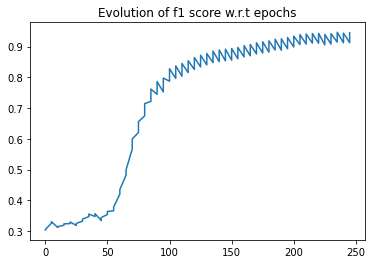

In [ ]:
do_train()

In [ ]:
do_test()

F1-Score: 0.9323
